# Visualisation of the rdii in borsuk

### Importing necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os.path
import statsmodels.api as sm
import statistics
import http.client
import json
import urllib.request
import requests
import random
from urllib import error
import configparser 
import datetime
import re

### Accessing the token
Pobranie danych dla kanału 

In [2]:
config = configparser.ConfigParser()
config.read("config.txt")

['config.txt']

In [3]:
http_client = config.get("configuration","http_client")
conn = http.client.HTTPConnection(http_client)
headers = {'Content-type': 'application/json'}

In [4]:
Username = config.get("configuration","user")
Password = config.get("configuration","password")

In [5]:
body = { 'Username': Username, 'Password': Password}
conn.request("POST","/auth/authenticate", json.dumps(body),headers)
response = conn.getresponse()
x = response.read().decode()
token = json.loads(x)['token']

### Loading the data set

In [6]:
url_rain = 'http://13.77.168.238/data/channel/3231-3048/data?token=' + token
url_flow = 'http://13.77.168.238/data/channel/1928-1363/data?token=' + token

In [7]:
df_rain = pd.read_csv(url_rain, parse_dates=['time'])
df_flow = pd.read_csv(url_flow, parse_dates=['time'])

In [8]:
df_flow.head()

,time,value
0,2011-07-12 12:15:00,2.267409
1,2011-07-12 12:30:00,2.314310
2,2011-07-12 12:45:00,2.259863
3,2011-07-12 13:00:00,2.153435
4,2011-07-12 13:15:00,2.085203


### Creating dataset where missing rows are given -1

In [9]:
df_rain = df_rain.set_index('time')
df_rain = df_rain.resample('300S').asfreq()

In [10]:
df_rain = df_rain.reset_index()

In [11]:
df_flow = df_flow.set_index('time')
df_flow = df_flow.resample('900S').asfreq()

In [12]:
df_flow = df_flow.reset_index()

In [13]:
df_rain = df_rain.fillna(-1)
df_flow = df_flow.fillna(-1)

### Taking the fragment of the data to the model

In [14]:
split_rain = df_rain[(df_rain['time'] > '2012-09-16 00:00:00')]
split_rain = split_rain[(split_rain['time'] < '2016-4-9 00:00:00')]
split_flow = df_flow[(df_flow['time'] > '2012-09-16 00:00:00')]
split_flow = split_flow[(split_flow['time'] < '2016-4-9 00:00:00')]

In [15]:
split_flow.head()

,time,value
41424,2012-09-16 00:15:00,1.018260
41425,2012-09-16 00:30:00,0.969223
41426,2012-09-16 00:45:00,0.983287
41427,2012-09-16 01:00:00,0.912357
41428,2012-09-16 01:15:00,0.867315


### Creating the json variable

In [16]:
 """ {
  "flow": {
    "start-date": "2012-09-16 00:30:00",
    "resolution": "PT15M",
    "values": []
  },
  "rainfall": {
    "start-date": "2012-09-16 00:30:00",
    "resolution": "PT5M",
    "values": []
  },
    "dryDayWindow": "P2D",
    "minSessionWindow": "PT12H",
    "maxSessionWindow": "PT24H"
} """

' {\n "flow": {\n   "start-date": "2012-09-16 00:30:00",\n   "resolution": "PT15M",\n   "values": []\n },\n "rainfall": {\n   "start-date": "2012-09-16 00:30:00",\n   "resolution": "PT5M",\n   "values": []\n },\n   "dryDayWindow": "P2D",\n   "minSessionWindow": "PT12H",\n   "maxSessionWindow": "PT24H"\n} '

In [17]:
rain_json = split_rain.to_json(orient='split')
flow_json = split_flow.to_json(orient='split')

In [18]:
rain_values = split_rain['value']
rain_values = np.array(rain_values)
rain_values = rain_values.tolist()

flow_values = split_flow['value']
flow_values = np.array(flow_values)
flow_values = flow_values.tolist()

In [19]:
rdii = {
  "flow": {
    "start-date": "2012-09-16",
    "resolution": "PT15M",
    "values": []
  },
  "rainfall": {
    "start-date": "2012-09-16",
    "resolution": "PT5M",
    "values": []
  },
    "dryDayWindow": "P2D",
    "minSessionWindow": "PT12H",
    "maxSessionWindow": "PT12H"
}

In [20]:
rdii['flow']['values'].append(flow_values)
rdii['rainfall']['values'].append(rain_values)

In [21]:
rdii = json.dumps(rdii)

In [22]:
rdii = rdii.replace('[[','[')
rdii = rdii.replace(']]',']')

In [23]:
rdii = json.loads(rdii)

### POST to borsuk-rdii alicja-test-model

In [24]:
#{"type":"rdiis-v0", "id": "model-id"}

In [25]:
rdii_url = config.get("configuration", "rdii_url")
body={"type":"storms-v0","id": "rdii_test"}
response = requests.post(rdii_url, json=body)
print(response.status_code)
print(response.content) 

409
b'Error: Model with this id already exist.'


### GET to borsuk-rdii alicja-test-model

In [26]:
rdii_model = config.get("configuration", "rdii_model")
r = requests.get(rdii_model)
first = json.loads(r.content)['build']
print(first)

7


### POST to borsuk json data fragment

In [27]:
body=rdii
url_fit = config.get("configuration", "rdii_fit")
response = requests.post(url_fit, json=body)
print(response.status_code)
print(response.content)

200
b'OK'


In [28]:
rdii = json.dumps(rdii)

### GET rdii
The change of status informs that the post is finished

In [30]:
print("Primary status: ",first)

Primary status:  7


In [31]:
import time
start_time = time.time()

while True:
    r = requests.get(rdii_model)
    last = json.loads(r.content)['build']
    if last > first:
        print("Status after post: ",last)
        break

print("--- %s seconds ---" % (time.time() - start_time))

Status after post:  8
--- 34.597336530685425 seconds ---


### Get rdii with dryDayWindow: P2D

In [32]:
rdii_session = config.get("configuration", "rdii_session")
r = requests.get(rdii_session)
session = json.loads(r.content)

### Get rdii with exemplary id

In [33]:
rdii_id = config.get("configuration", "rdii_id")
rdii_id = rdii_id + '/2'
r = requests.get(rdii_id)
b = json.loads(r.content)

### Create variables from json

In [34]:
st_date = b['start-date']
en_date = b['end-date']
dwp = b['dwp']
flow = b['flow']
rain = b['rainfall']
rdii_v = b['rdii']
print(st_date, en_date)

2012-10-13T00:00 2012-10-16T23:45


In [35]:
dt = datetime.datetime(2012, 10, 13)
end = datetime.datetime(2012, 10, 17, 0)
step = datetime.timedelta(seconds=900)

result = []

while dt < end:
    result.append(dt.strftime('%Y-%m-%d %H:%M:%S'))
    dt += step

In [36]:
result = pd.DataFrame(result)
dwp = pd.DataFrame(dwp)
flow = pd.DataFrame(flow)
rain = pd.DataFrame(rain)
rdii_v = pd.DataFrame(rdii_v)

In [37]:
result = pd.to_datetime(result[0])

In [38]:
result.head()

0   2012-10-13 00:00:00
1   2012-10-13 00:15:00
2   2012-10-13 00:30:00
3   2012-10-13 00:45:00
4   2012-10-13 01:00:00
Name: 0, dtype: datetime64[ns]

In [39]:
result.tail()

379   2012-10-16 22:45:00
380   2012-10-16 23:00:00
381   2012-10-16 23:15:00
382   2012-10-16 23:30:00
383   2012-10-16 23:45:00
Name: 0, dtype: datetime64[ns]

### Rolling window on borsuk dwp

In [40]:
rdii_roll = rdii_v.rolling(4).mean()
rdii_roll = rdii_roll.fillna(rdii_roll.mean())

# Comparing results with rdii from flowworks.http

### Get data from flowworks

In [41]:
flowworks = config.get("configuration", "flowworks")
r = requests.get(flowworks)
flow_data = json.loads(r.content)

### Create variables for plot

In [42]:
flow_datetime = flow_data['index']
flow_dwp = flow_data['dwp']
flow_flow = flow_data['flow']
flow_rain = flow_data['rainfall']
flow_rdii = flow_data['rdii1']

In [43]:
flow_datetime =pd.DataFrame(flow_datetime)

In [44]:
flow_datetime[0] = flow_datetime[0].replace({'T':' '}, regex=True)
flow_datetime[0] = flow_datetime[0].replace({'Z':' '}, regex=True)

In [45]:
flow_datetime[0] = pd.to_datetime(flow_datetime[0])

### Plotting rdii from flowworks.http

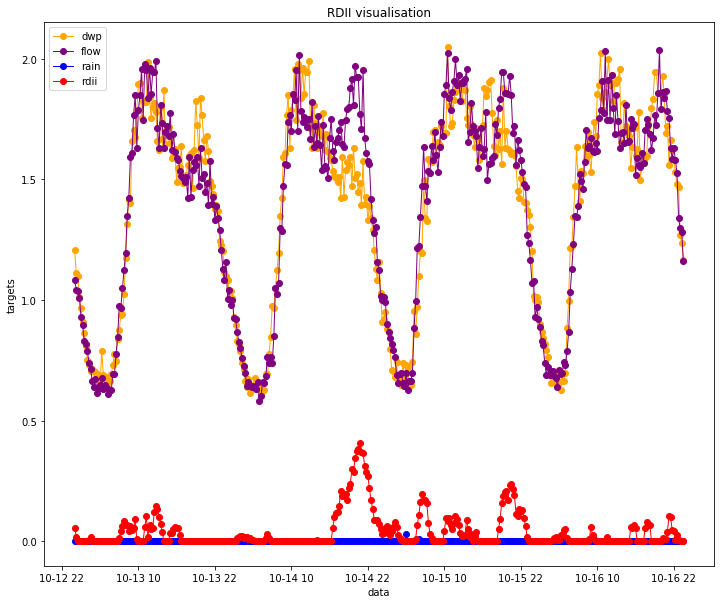

In [46]:
plt.figure(figsize=(12, 10))
plt.plot(flow_datetime, flow_dwp, color="orange",marker="o",label="dwp", linewidth=1)
plt.plot(flow_datetime, flow_flow, c='purple',marker="o", label="flow",linewidth=1)
plt.plot(flow_datetime, flow_rain, c='blue',marker="o", label="rain",linewidth=1)
plt.plot(flow_datetime, flow_rdii, c='red',marker="o", label="rdii",linewidth=1)

plt.xlabel("data")
plt.ylabel("targets")
plt.title("RDII visualisation")
plt.legend()
plt.show()

### Plotting rdii from borsuk

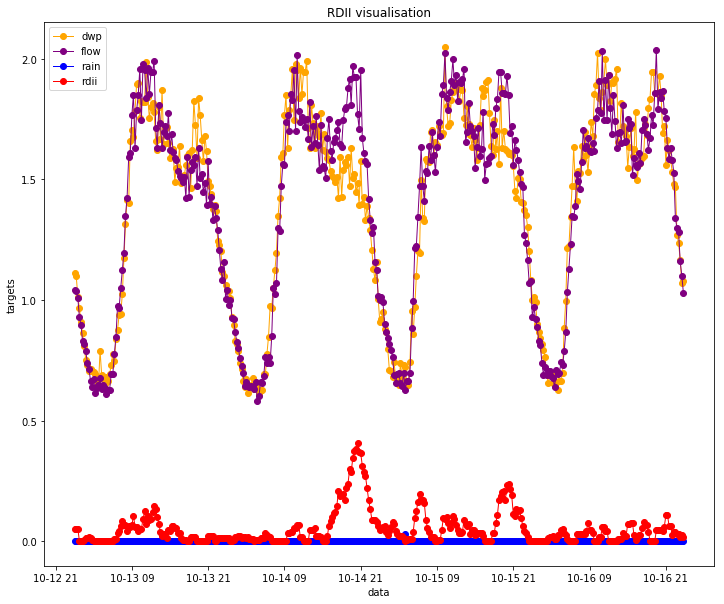

In [47]:
plt.figure(figsize=(12, 10))
plt.plot(result, dwp, color="orange",marker="o",label="dwp", linewidth=1)
plt.plot(result, flow, c='purple',marker="o", label="flow",linewidth=1)
plt.plot(result, rain, c='blue',marker="o", label="rain",linewidth=1)
plt.plot(result, rdii_roll, c='red',marker="o", label="rdii",linewidth=1)

plt.xlabel("data")
plt.ylabel("targets")
plt.title("RDII visualisation")
plt.legend()
plt.show()